In [4]:
import os
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import librosa
from IPython.display import Audio

In [5]:
def getData(speaker, d, idx):
    audio, sample_rate = librosa.load(os.path.join('data', speaker, f'{str(d)}_{speaker}_{str(idx)}.wav'), sr=16000)
    return audio, sample_rate

In [6]:
def playAudio(speaker, d, idx):
    audio, sr = getData(speaker, d, idx)

    plt.figure(figsize=(8,2))
    plt.plot(np.linspace(0, len(audio)/sr, len(audio)), audio)
    return display(Audio(data=audio, rate=sr))

In [7]:
def spectogram(speaker, d, idx):
    audio, sr = getData(speaker, d, idx)

    S = librosa.stft(audio) # Short-Time-Fourier-Transformer
    Sdb = librosa.amplitude_to_db(np.abs(S), ref=np.max) # Convert to dB
    librosa.display.specshow(Sdb, x_axis='time', y_axis='log')

In [8]:
def vis(func, sp, w=8, h=2):
    for i in range(10):
        func(sp, i, 1)
        plt.title(f'Digit {i}')
        plt.show()

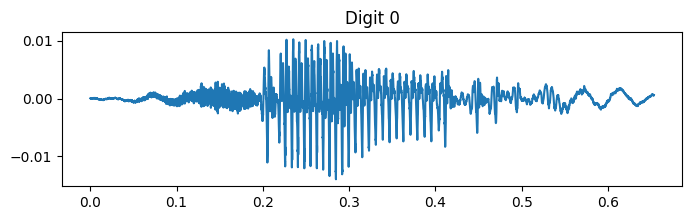

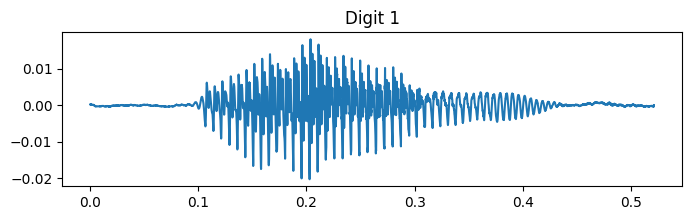

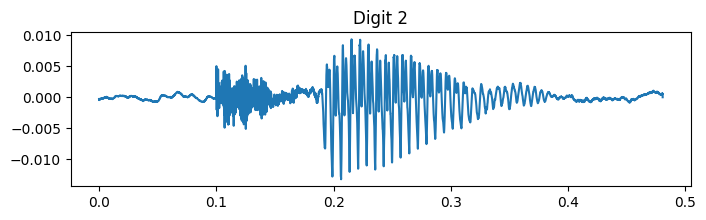

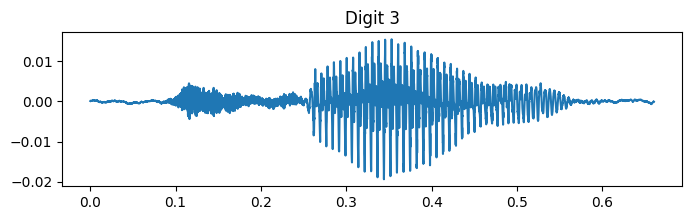

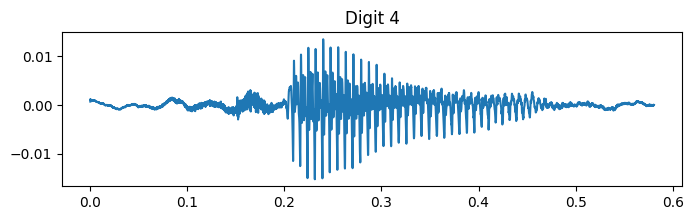

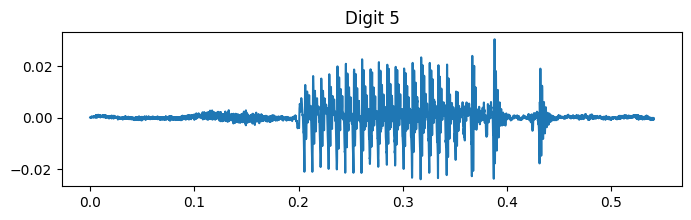

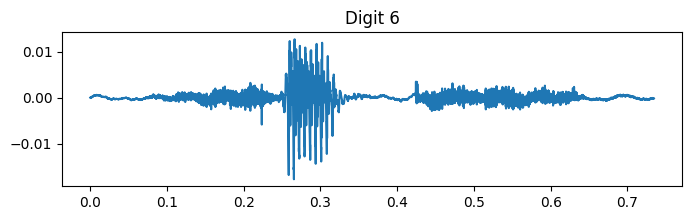

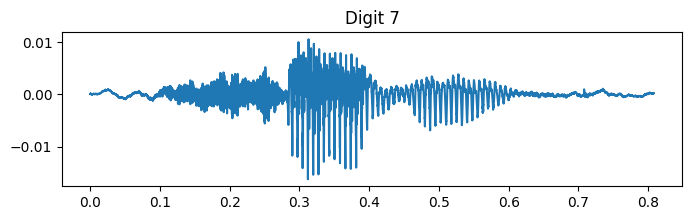

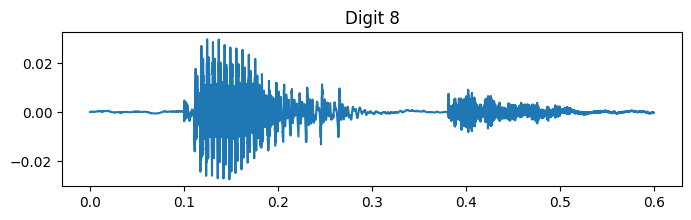

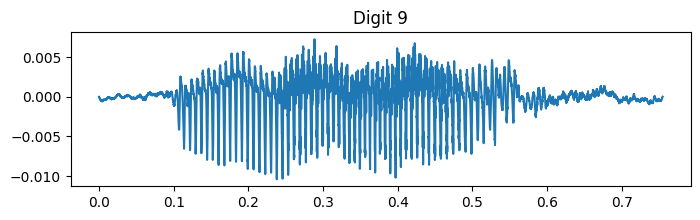

In [9]:
vis(playAudio, '01')

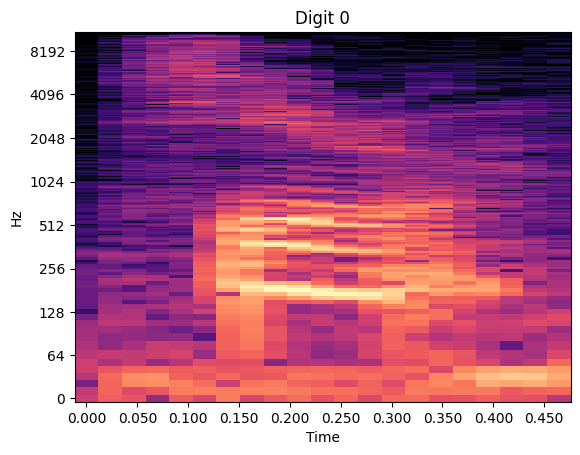

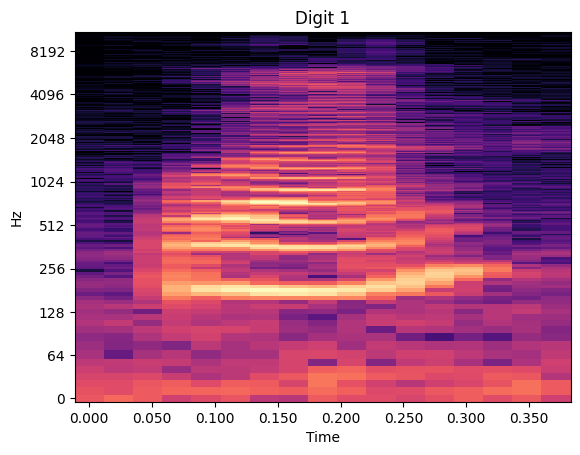

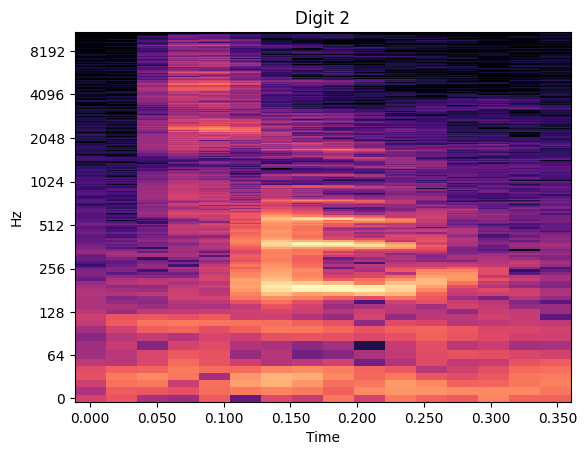

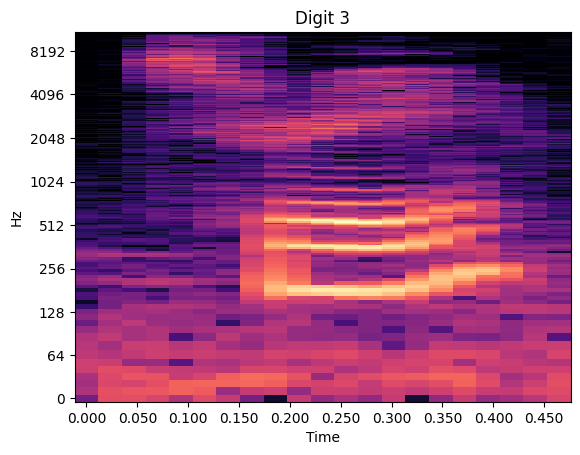

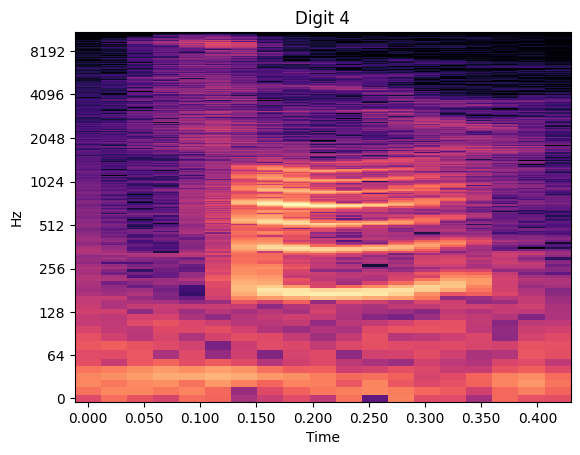

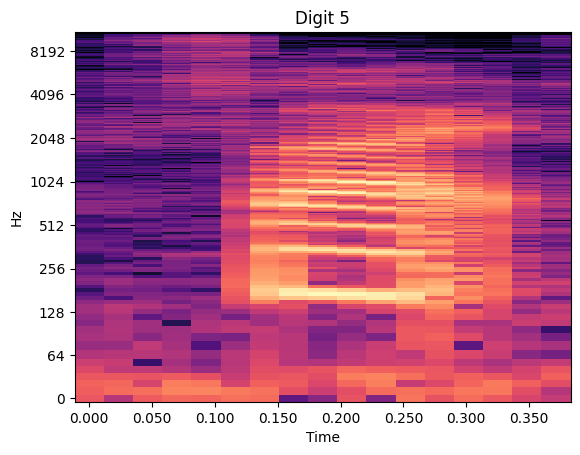

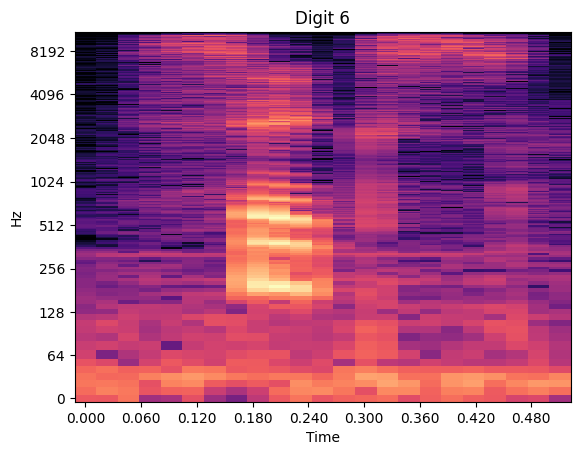

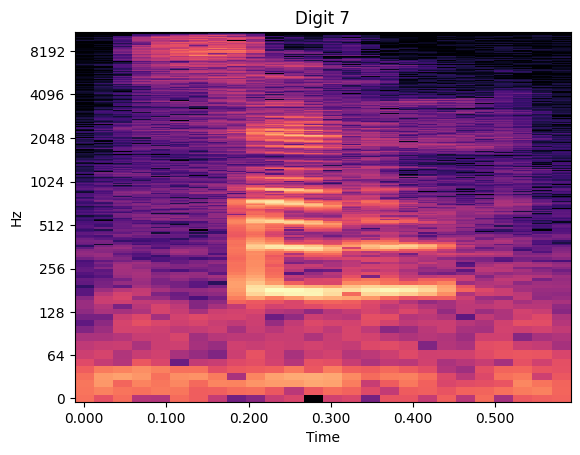

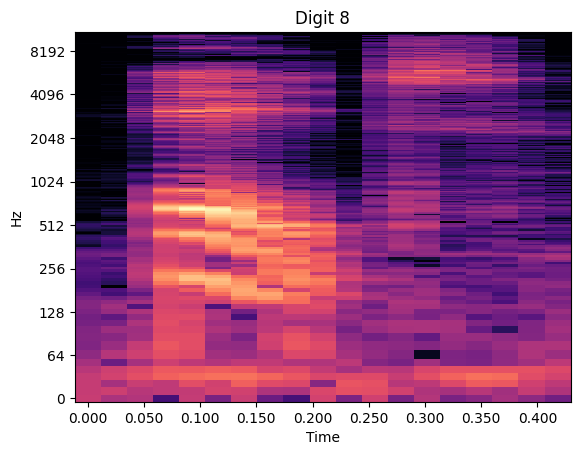

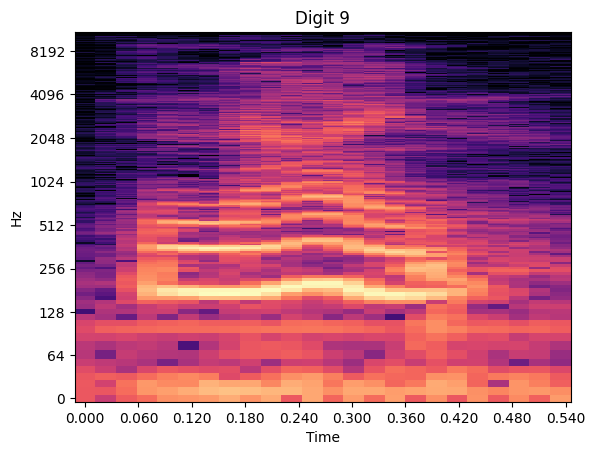

In [10]:
vis(spectogram, '01')

In [11]:
def getFeatures(sp, d, idx):
    audio, sr = getData(sp, d, idx)
    features = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40) # Mel-frequency cepstral coefficients
    return np.mean(features.T, axis=0) # Scale

In [12]:
def createDataset():
    dataset = []

    for speaker in range(1, 61):
        if speaker < 10:
            sp = f'0{speaker}'
        else:
            sp = str(speaker)
        
        for digit in range(10):
            for i in range(50):
                dataset.append([getFeatures(sp, digit, i), digit])

    return pd.DataFrame(dataset, columns=['features', 'label'])

In [13]:
dataset = createDataset()

In [14]:
from sklearn.model_selection import train_test_split
X = np.array(dataset['features'].to_list())
Y = np.array(dataset['label'].to_list())
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.70, shuffle=True, random_state=643)

In [15]:
from tensorflow import keras
from keras import layers, Sequential, Input
import pydot
import graphviz

In [16]:
model = Sequential([
    Input(shape=(40, )),
    layers.Dense(128, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation="softmax")
])

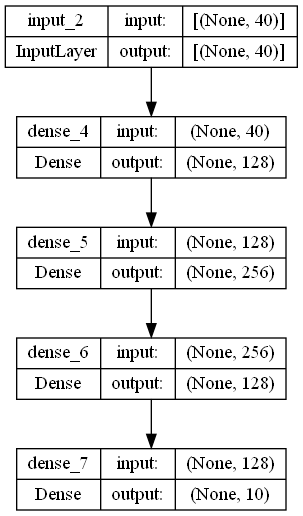

In [17]:
keras.utils.plot_model(model, show_shapes=True)

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               5248      
                                                                 
 dense_5 (Dense)             (None, 256)               33024     
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dense_7 (Dense)             (None, 10)                1290      
                                                                 
Total params: 72,458
Trainable params: 72,458
Non-trainable params: 0
_________________________________________________________________


In [19]:
epochs = 100
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1,  restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau( monitor="val_loss", factor=0.5, patience=1, verbose=1)
]

In [20]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Adam(1e-3), metrics=["accuracy"])

In [21]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, callbacks=callbacks, validation_data=(X_test, y_test))

Epoch 1/100
657/657 [==============================] - 2s 2ms/step - loss: 1.2822 - accuracy: 0.6948 - val_loss: 0.4801 - val_accuracy: 0.8233 - lr: 0.0010
Epoch 2/100
657/657 [==============================] - 1s 2ms/step - loss: 0.4783 - accuracy: 0.8259 - val_loss: 0.4540 - val_accuracy: 0.8396 - lr: 0.0010
Epoch 3/100
657/657 [==============================] - 1s 2ms/step - loss: 0.3737 - accuracy: 0.8639 - val_loss: 0.3319 - val_accuracy: 0.8794 - lr: 0.0010
Epoch 4/100
657/657 [==============================] - 1s 2ms/step - loss: 0.3073 - accuracy: 0.8859 - val_loss: 0.2879 - val_accuracy: 0.8962 - lr: 0.0010
Epoch 5/100
657/657 [==============================] - 1s 2ms/step - loss: 0.2542 - accuracy: 0.9060 - val_loss: 0.2395 - val_accuracy: 0.9170 - lr: 0.0010
Epoch 6/100
657/657 [==============================] - 2s 2ms/step - loss: 0.2164 - accuracy: 0.9220 - val_loss: 0.2140 - val_accuracy: 0.9221 - lr: 0.0010
Epoch 7/100
657/657 [==============================] - 2s 2ms/st

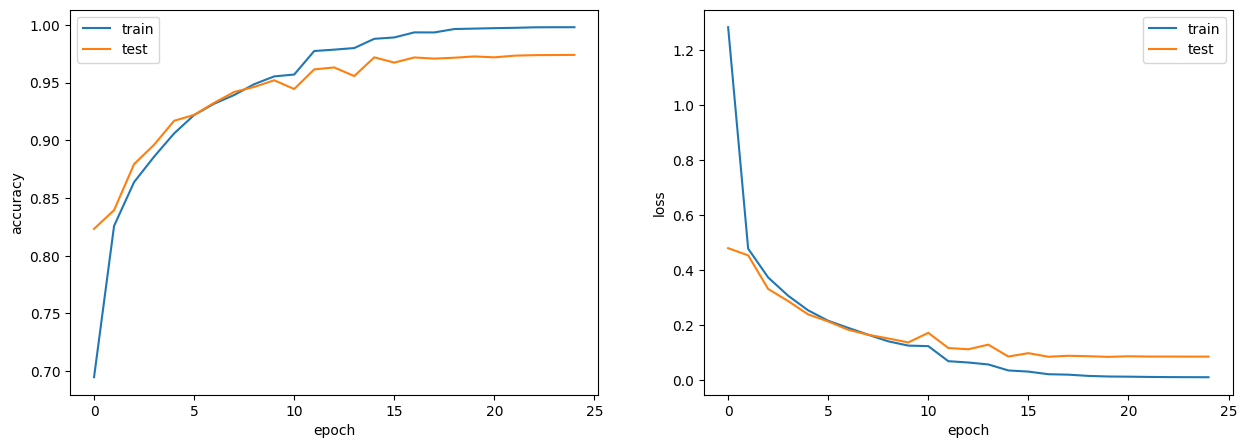

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'test'])


ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'test'])

In [23]:
y_pred = model.predict(X_test)
y_pred = [np.argmax(i) for i in y_pred]

282/282 [==============================] - 0s 968us/step


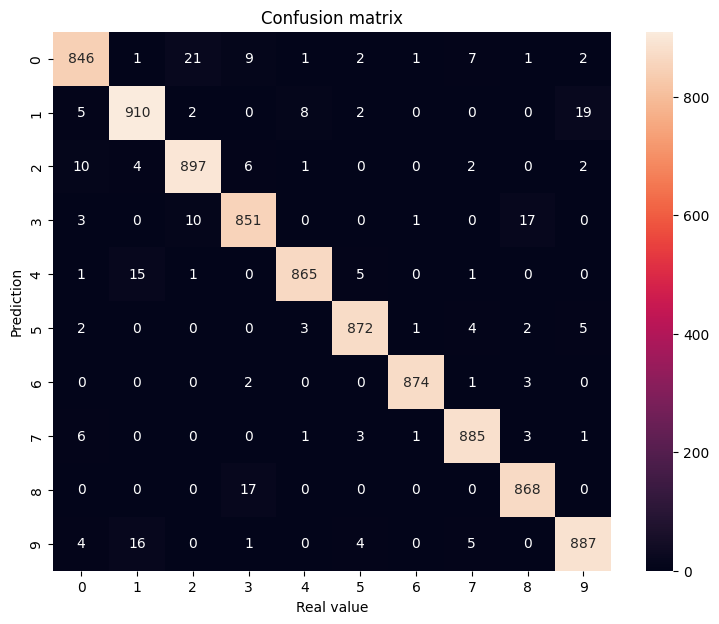

In [24]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(9, 7))
sns.heatmap(matrix, annot=True, fmt='g')
plt.xlabel("Real value")
plt.ylabel("Prediction")
plt.title('Confusion matrix')
plt.show()

In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96       891
           1       0.96      0.96      0.96       946
           2       0.96      0.97      0.97       922
           3       0.96      0.96      0.96       882
           4       0.98      0.97      0.98       888
           5       0.98      0.98      0.98       889
           6       1.00      0.99      0.99       880
           7       0.98      0.98      0.98       900
           8       0.97      0.98      0.98       885
           9       0.97      0.97      0.97       917

    accuracy                           0.97      9000
   macro avg       0.97      0.97      0.97      9000
weighted avg       0.97      0.97      0.97      9000

